In [ ]:
# for now, just request a random composite spectrum from facula_and_spot_creator
# and try to decompose it - aka can we regenerate the w's

# eventually can read in external data or some training data from a large hdf5 file etc

from itertools import product
from pathlib import Path
import astropy
from astropy.table import QTable
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
from astropy.visualization import quantity_support
quantity_support()
from tqdm import tqdm
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.units import Quantity
from joblib import Parallel, delayed
import os

from spots_and_faculae_model.spectrum_utils import normalise_Janskys
from phoenix_grid_creator.fits_to_hdf5 import FLUX_COLUMN, TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WAVELENGTH_COLUMN
from spectrum_component_analyser.external_spectrum_reader import get_external_spectra, read_JWST_fits

# # # # # helper functions # # # # #

from astropy.constants import h, c

def convert_flux_to_Janskys(wavelength : np.array, counts : np.array):
	"""
	wavelength should be an array of astropy quantities (with units of length)
	"""

	return (counts * [a.value**2 for a in wavelength]) * u.Jy
	energy = h * c / wavelength
	
	frequency = c / wavelength

	total_energy = energy * counts
	janskys = 10e-26 * (total_energy / u.second) / (u.m**2 * frequency)
	return janskys

if __name__ == "__main__":
	external_spectrum_path = Path("../../assets/MAST_2025-10-26T19_44_50.934Z - TRAPPIST-1/MAST_2025-10-26T19_44_50.934Z/JWST/jw02589001001_04101_00001-seg001_nis_x1dints.fits")
	script_dir = os.getcwd()  # usually the folder where notebook is running")
	wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()
	absolute_external_spectrum = wavelength_grid_absolute_path.resolve()

	spectrum_to_decompose = read_JWST_fits(wavelength_grid_absolute_path)
	
	orig_spectrum_to_decompose = spectrum_to_decompose
	spectrum_to_decompose = spectrum_to_decompose[np.isfinite(orig_spectrum_to_decompose[FLUX_COLUMN])]
	
	# spectrum_to_decompose = spectrum_to_decompose[(0.5 * u.um <= spectrum_to_decompose[WAVELENGTH_COLUMN])]
	# plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN])
	# plt.show()
	print("reading in hdf5")
	all_data : QTable = get_hdf5_data()
	print("finished reading in hdf5")

	print("normalising counts")

	# plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN], label="unnormalised real spectrum to componentise")
	spectrum_to_decompose[FLUX_COLUMN] = normalise_Janskys(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN])
	# spectrum_to_decompose[FLUX_COLUMN] = sp.signal.medfilt(spectrum_to_decompose[FLUX_COLUMN], kernel_size=[5])
	# plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN], label="normalised real spectrum to componentise")
	# plt.legend()
	# plt.show()

	print("finished normalising counts")
	# print(spectrum_to_decompose)
	# plt.show()

	A = np.empty((0, 0))

	# this is slow but gives us all the parameters saved to the spectral grid
	T_effs = astropy.table.unique(all_data, keys=[TEFF_COLUMN])[TEFF_COLUMN]
	T_effs = T_effs[(2300 *u.K <= T_effs) & (T_effs <= 3000*u.K)]
	
	FeHs = astropy.table.unique(all_data, keys=[FEH_COLUMN])[FEH_COLUMN]
	log_gs = astropy.table.unique(all_data, keys=[LOGG_COLUMN])[LOGG_COLUMN]

	JWST_resolution = .001 * u.um # we will convolve our simulated data over this range before sampling it

	# print(spectrum_to_decompose)

	def process_single_spectral_component(T_eff : Quantity[u.K], FeH : float, log_g : float):
		subset = all_data[(all_data[TEFF_COLUMN] == T_eff) &
						  (all_data[FEH_COLUMN] == FeH) &
						  (all_data[LOGG_COLUMN] == log_g)]
		
		# remove the indices that were nan in the spectrum
		subset = subset[np.isfinite(orig_spectrum_to_decompose[FLUX_COLUMN])]

		flux = convert_flux_to_Janskys(spectrum_to_decompose[WAVELENGTH_COLUMN], subset[FLUX_COLUMN])
		flux = normalise_Janskys(spectrum_to_decompose[WAVELENGTH_COLUMN], flux)
		return flux
	
	results = Parallel(n_jobs=-1, prefer="threads")(
		delayed(process_single_spectral_component)(T_eff, FeH, log_g) for T_eff, FeH, log_g in tqdm(product(T_effs, FeHs, log_gs), total=len(T_effs) * len(FeHs) * len(log_gs), desc="Appending values to A matrix...")
		)
	
	A = np.column_stack(results)
	print("minimising")
	# assume that w \in [0,1] : but I think this will only be true for real data if normalisation has been done correctly (???)
	result = sp.optimize.lsq_linear(A, spectrum_to_decompose[FLUX_COLUMN], bounds = (0, 1), verbose = 2)#, max_iter=600, tol=1e-10, lsmr_tol=1e-5)
	print(result)
	print(f"sum of weights={np.sum(result.x)}")

Filename: /home/bengreen/University/Part III/stellar-heterogeneity-modelling/spots_and_faculae_model/assets/MAST_2025-10-26T19_44_50.934Z - TRAPPIST-1/MAST_2025-10-26T19_44_50.934Z/JWST/jw02589001001_04101_00001-seg001_nis_x1dints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     367   ()      
  1  SCI           1 ImageHDU        32   ()      
  2  INT_TIMES     1 BinTableHDU     24   79R x 7C   [J, D, D, D, D, D, D]   
  3  EXTRACT1D     1 BinTableHDU    102   79R x 27C   [J, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, 2048J, 2048D, 2048D, 2048D, 2048D, 2048D, 2048D, J, J, D, D, D, D, D, D]   
  4  EXTRACT1D     2 BinTableHDU    102   79R x 27C   [J, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, 1783J, 1783D, 1783D, 1783D, 1783D, 1783D, 1783D, J, J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [1033763B]   
XTENSION= 'BINTABLE'           / b

Appending values to A matrix...: 100%|██████████| 936/936 [00:10<00:00, 92.17it/s]


minimising
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         5.1020e+08                                    3.28e+06    
       1         4.9568e+08      1.45e+07       4.03e+00       3.24e+06    
       2         4.9245e+08      3.23e+06       0.00e+00       3.13e+06    
       3         4.8932e+08      3.13e+06       0.00e+00       3.09e+06    
       4         4.8624e+08      3.09e+06       0.00e+00       3.08e+06    
       5         4.8316e+08      3.07e+06       0.00e+00       3.04e+06    
       6         4.8013e+08      3.03e+06       0.00e+00       3.02e+06    
       7         4.7711e+08      3.02e+06       0.00e+00       3.01e+06    
       8         4.7410e+08      3.01e+06       0.00e+00       2.99e+06    
       9         4.7112e+08      2.99e+06       0.00e+00       2.97e+06    
      10         4.6815e+08      2.96e+06       0.00e+00       2.96e+06    
      11         4.6520e+08      2.95e+06       0.00e+00       2.93e+06    
 

In [14]:
%matplotlib widget

/tmp/ipykernel_40954/3604205735.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


    T_eff / K  Fe/H / relative to solar  log_g / log(cm s^(-2))        weight
511  2700.0 K                      -1.5                     2.0  2.084946e-01
276  2500.0 K                      -1.5                     1.5  2.059939e-01
290  2500.0 K                      -1.0                     2.0  1.960520e-01
111  2300.0 K                       1.0                     3.5  1.329987e-01
923  3000.0 K                       1.0                     0.0  5.353616e-02
116  2300.0 K                       1.0                     6.0  2.953285e-03
910  3000.0 K                       0.5                     0.0  9.610551e-04
388  2600.0 K                      -2.0                     5.5  1.110223e-16
419  2600.0 K                      -0.5                     1.5  1.110223e-16
387  2600.0 K                      -2.0                     5.0  1.110223e-16


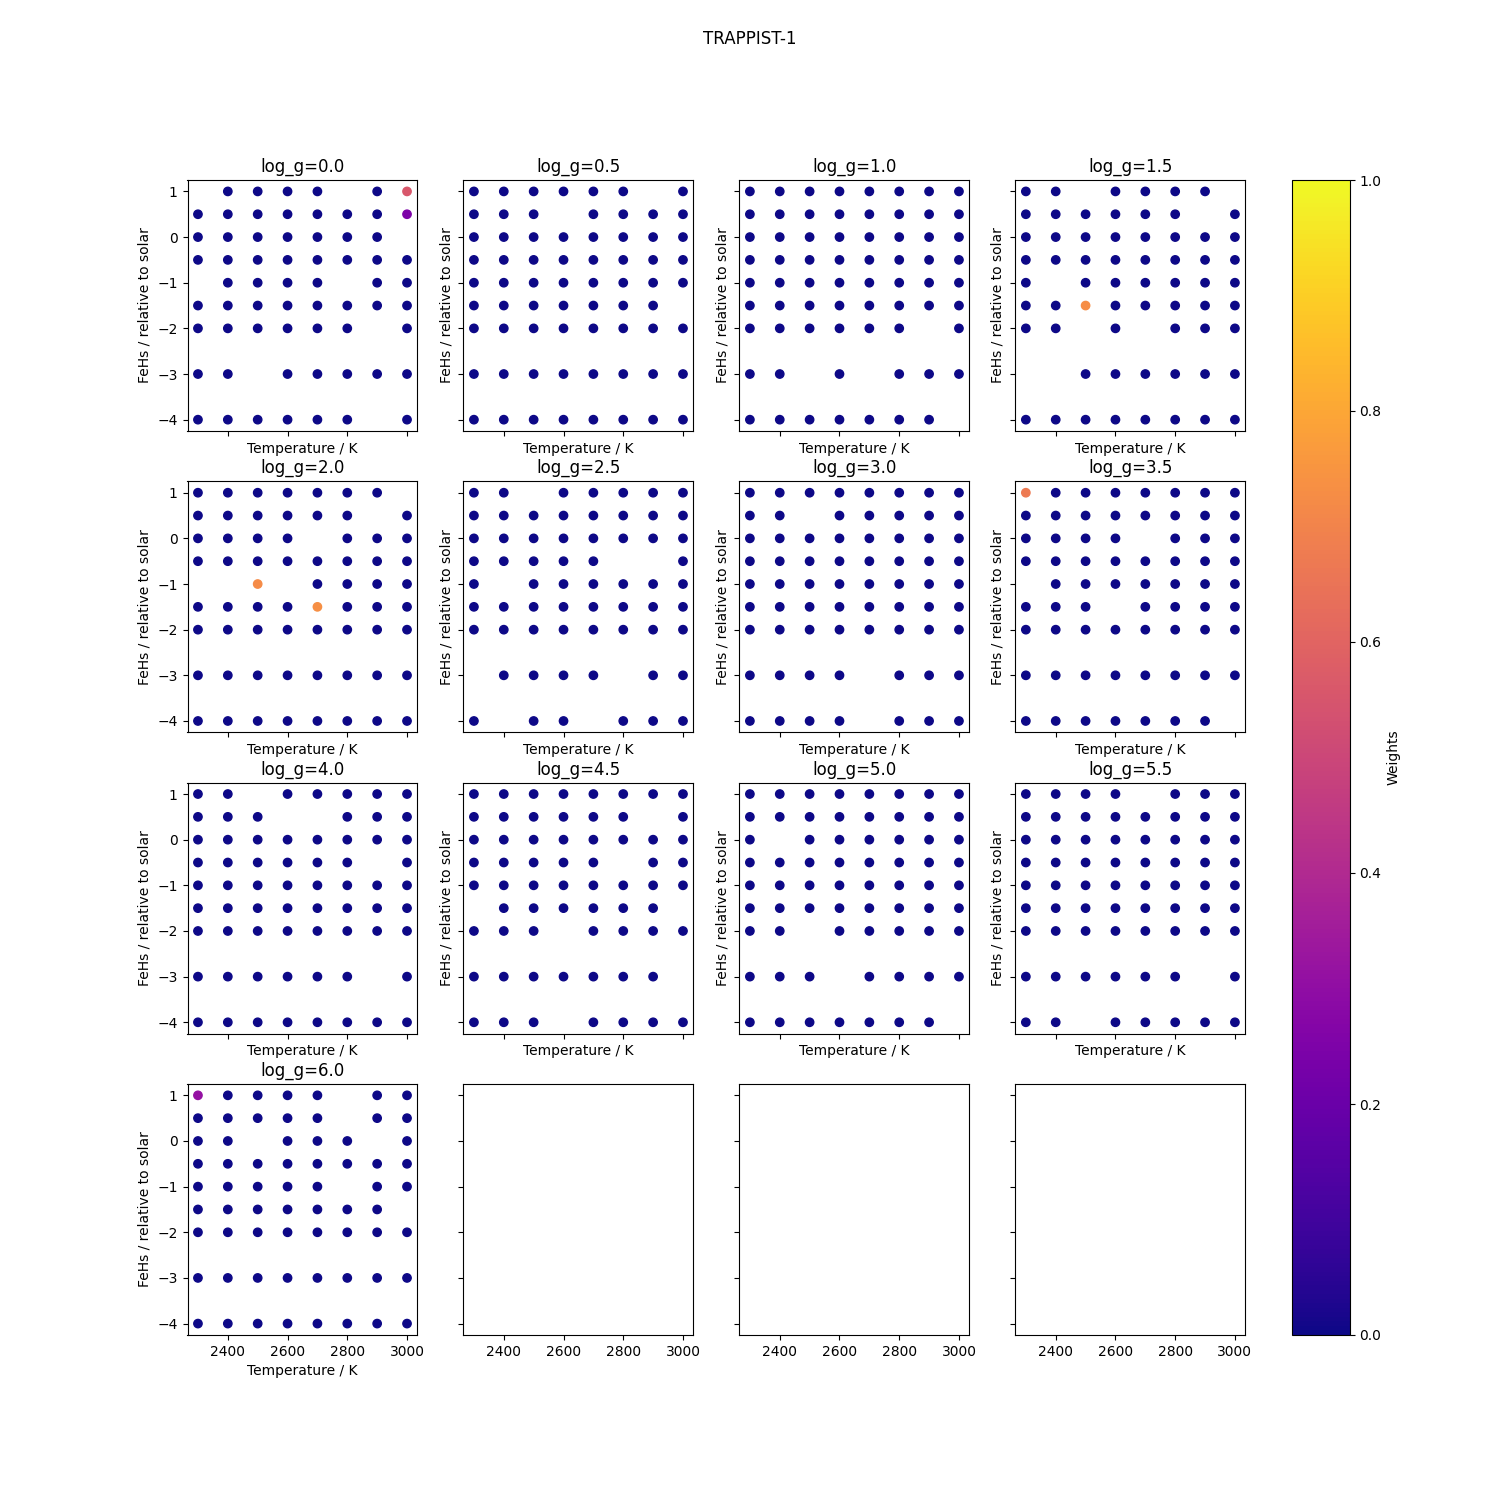

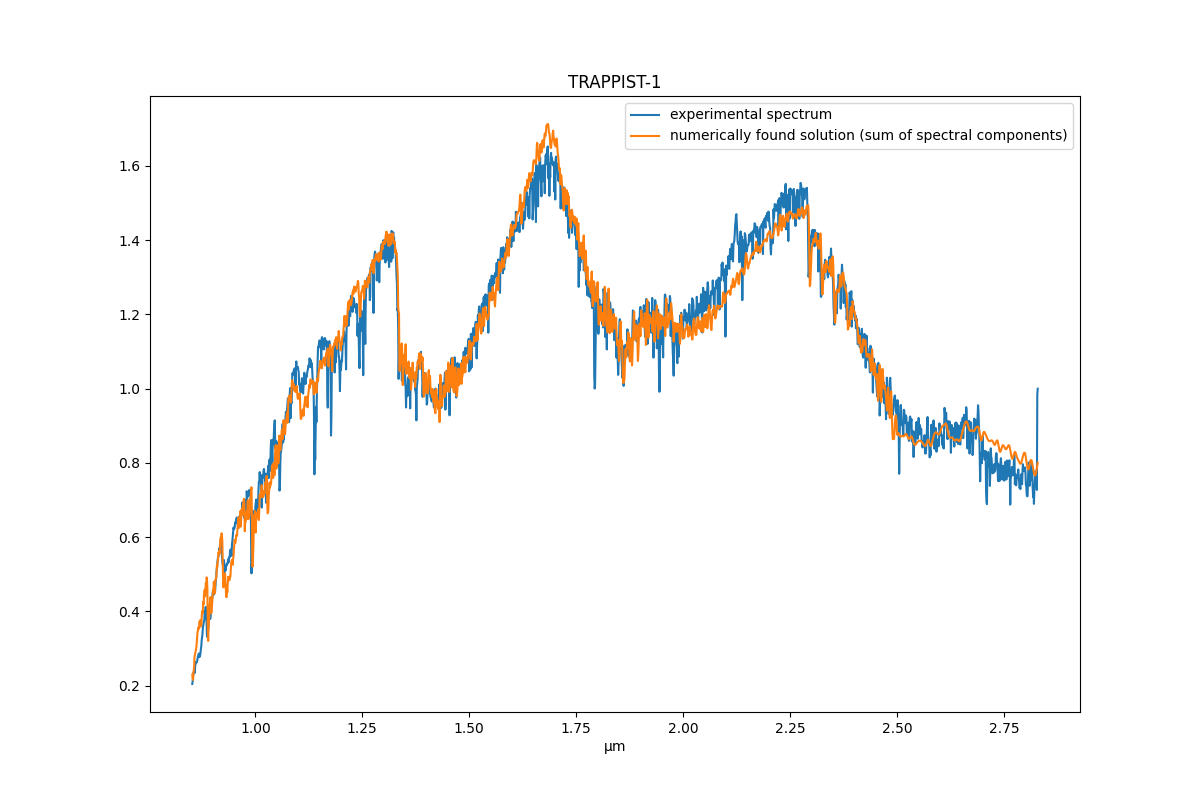

In [44]:

# # # plot some data # # #

result_map = {}
i = 0
for T_eff, FeH, log_g in product(T_effs, FeHs, log_gs):
    key = (T_eff, FeH, log_g)
    result_map[key] = i
    i += 1

    from phoenix_grid_creator.fits_to_hdf5 import TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN

WEIGHT_COLUMN : str = "weight"

hash_map = pd.DataFrame(columns=[TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WEIGHT_COLUMN])

for T_eff, FeH, log_g in product(T_effs, FeHs, log_gs):
    new_row = {TEFF_COLUMN: T_eff, FEH_COLUMN: FeH, LOGG_COLUMN: log_g, WEIGHT_COLUMN: result.x[result_map[(T_eff, FeH, log_g)]]}
    hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)

print(hash_map.sort_values(WEIGHT_COLUMN, ascending=False)[0:10])

fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.ravel()
for i, log_g in enumerate(log_gs):
    subset = hash_map[hash_map[LOGG_COLUMN] == log_g]
    x_vals = [a.value for a in subset[TEFF_COLUMN]]
    y_vals = subset[FEH_COLUMN]
    z_vals = subset[WEIGHT_COLUMN]

    sc = axes[i].scatter(x_vals, y_vals, c=z_vals**.2, cmap='plasma', vmin=0, vmax=1)

    axes[i].set_title(f"log_g={log_g}")
    axes[i].set_xlabel("Temperature / K")
    axes[i].set_ylabel("FeHs / relative to solar")
    # axes[i].set_xticks(np.arange(np.min(T_effs) / u.K, np.max(T_effs) / u.K + 1, 50) * u.K)
    # axes[i].grid()

STAR_NAME : str = "TRAPPIST-1"
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Weights")
fig.suptitle(STAR_NAME)
plt.show()

plt.figure(figsize=(12,8))
plt.title(STAR_NAME)
plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], spectrum_to_decompose[FLUX_COLUMN], label="experimental spectrum")
plt.plot(spectrum_to_decompose[WAVELENGTH_COLUMN], A @ result.x, label="numerically found solution (sum of spectral components)")

plt.legend()
plt.show()